In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False
from tqdm import tqdm

In [2]:
df = pd.read_csv('C:/Users/user/github/Data/energy/train.csv', encoding='cp949')

In [3]:
df.date_time = pd.to_datetime(df.date_time)

In [4]:
df_1 = df[df['num']==1]

In [5]:
df_1

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2035,1,2020-08-24 19:00:00,8714.952,29.4,3.4,66.0,0.0,0.2,0.0,0.0
2036,1,2020-08-24 20:00:00,8740.224,28.7,1.9,69.0,0.0,0.0,0.0,0.0
2037,1,2020-08-24 21:00:00,8730.504,28.3,1.1,71.0,0.0,0.0,0.0,0.0
2038,1,2020-08-24 22:00:00,8725.968,28.3,2.4,72.0,0.0,0.0,0.0,0.0


In [6]:
df_1 = df_1.set_index(['date_time'])

<Axes: xlabel='date_time'>

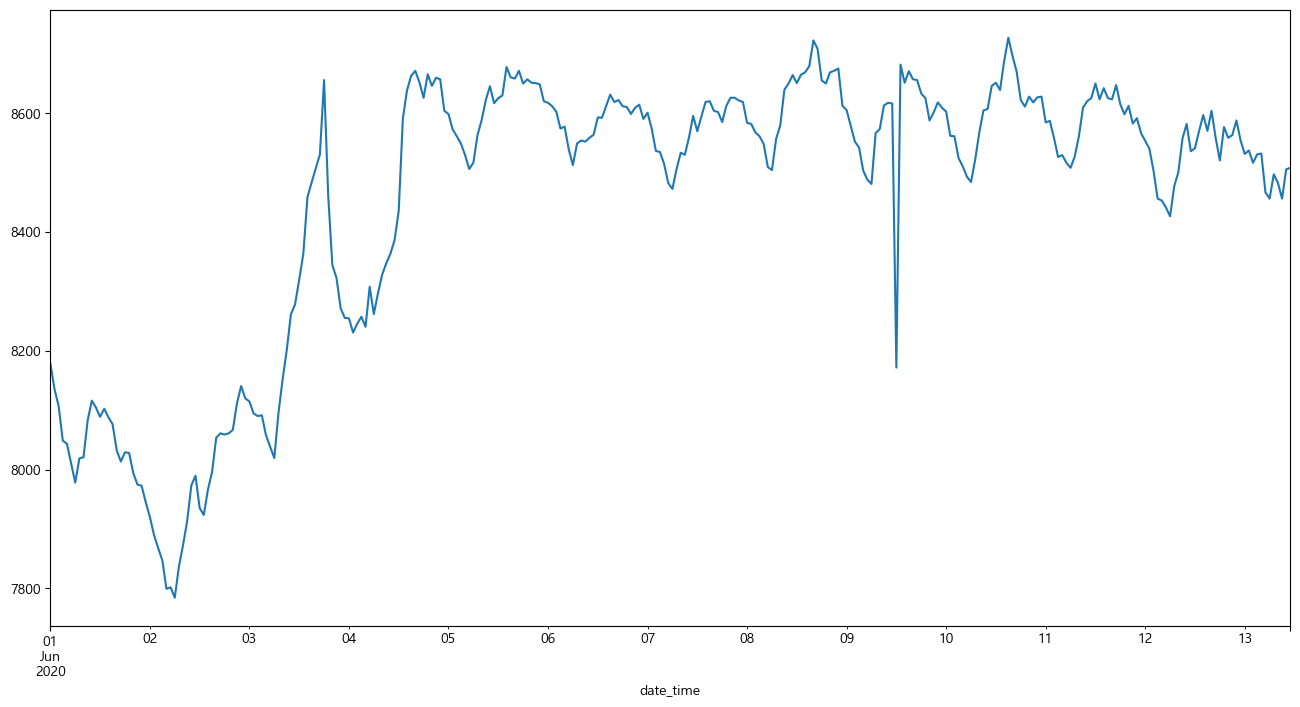

In [7]:
df_1.iloc[:300,1].plot(figsize=(16,8))

<Axes: xlabel='date_time'>

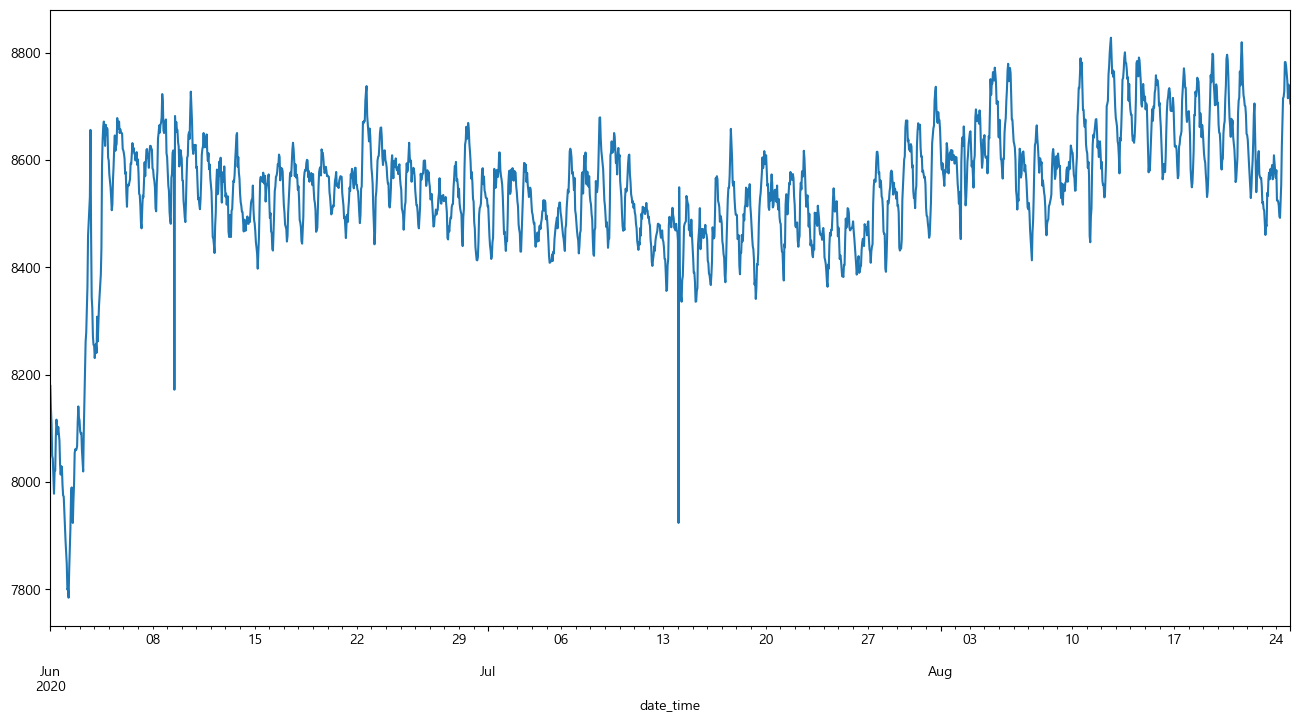

In [8]:
df_1['전력사용량(kWh)'].plot(figsize=(16,8))

In [9]:
group = df.groupby(['num','date_time']).mean()

<Axes: xlabel='num', ylabel='전력사용량(kWh)'>

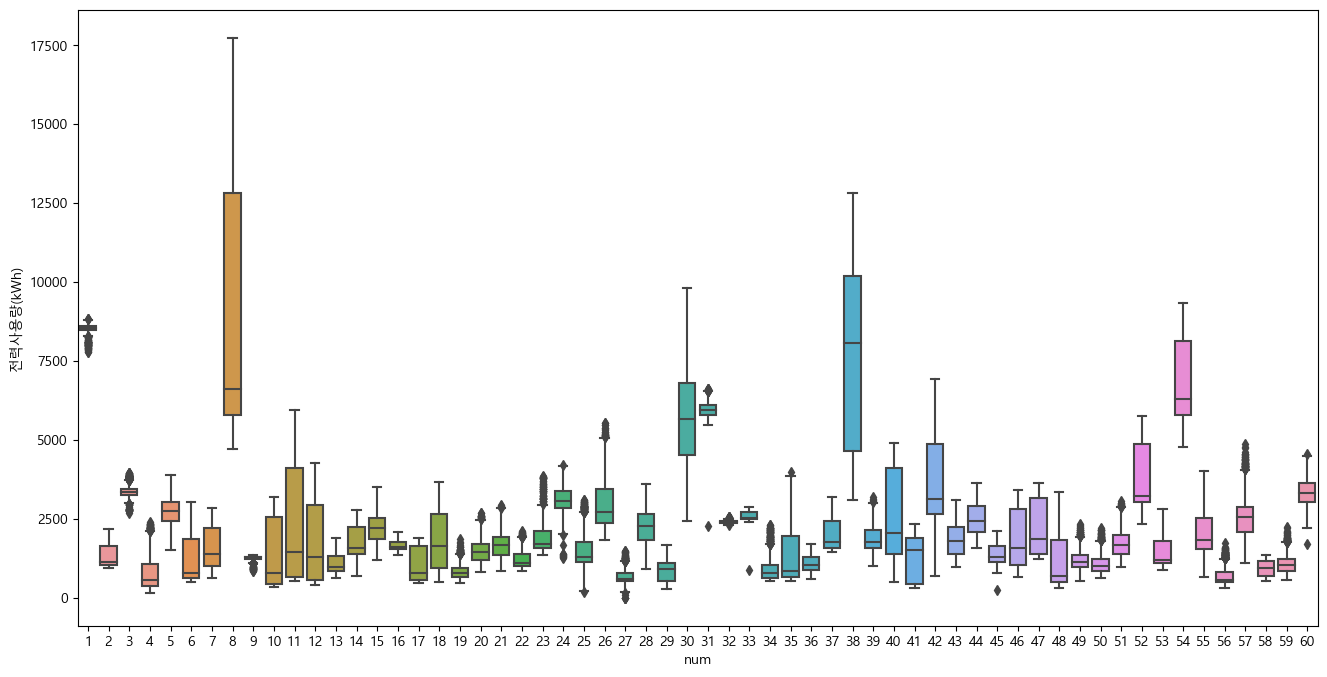

In [10]:
plt.figure(figsize=(16,8))
sns.boxplot(x='num', y='전력사용량(kWh)', data=df)

<Axes: xlabel='date_time', ylabel='전력사용량(kWh)'>

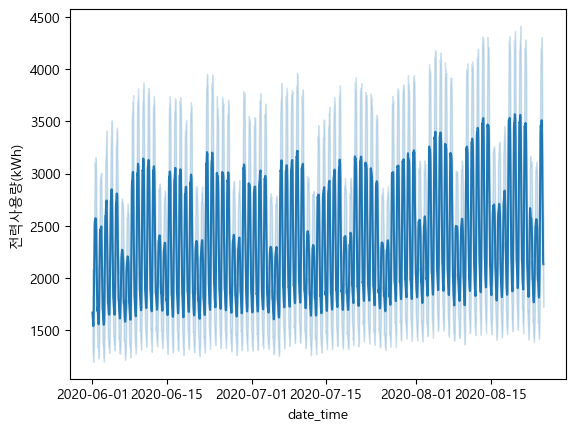

In [11]:
sns.lineplot(x='date_time', y='전력사용량(kWh)', data = df.groupby(['num','date_time']).mean())

In [12]:
eda_df = df.copy()

In [13]:
eda_df['month'] = 0
eda_df['hour'] = 0
eda_df['year'] = 0
eda_df['day'] = 0
eda_df['요일'] = 0

In [14]:
import datetime

In [15]:
days = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

In [16]:
for i in tqdm(range(len(eda_df))):
    eda_df['month'][i] = eda_df.date_time[i].month
    eda_df['hour'][i] = eda_df.date_time[i].hour
    eda_df['year'][i] = eda_df.date_time[i].year
    eda_df['day'][i] = eda_df.date_time[i].day
    eda_df['요일'][i] = days[eda_df.date_time[i].weekday()]

100%|██████████| 122400/122400 [01:06<00:00, 1829.39it/s]


In [17]:
input = eda_df.drop(['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','month'], axis=1)

In [18]:
mean = pd.DataFrame(input.groupby(['num','요일','hour']).mean()['전력사용량(kWh)'])

In [19]:
std = pd.DataFrame(input.groupby(['num','요일','hour']).std()['전력사용량(kWh)'])

In [20]:
total_df = pd.merge(mean, std, how='inner', left_on = ['num','요일','hour'], right_on=['num','요일','hour'])

In [21]:
total_df.reset_index(inplace=True)

In [22]:
total_df.columns = ['num' ,'요일', 'hour', 'mean', 'std']

for i in range(1,61):
    sns.boxplot(x = '요일', y = '전력사용량(kWh)', data = eda_df[eda_df['num'] == i])
    plt.title('{} 기업 요일별 전력사용량'.format(i))
    plt.savefig('./energy_plot/요일별_전력사용량_{}.png'.format(i))
    plt.cla()
    for j in days:
        sns.boxplot(x = 'hour', y = '전력사용량(kWh)', data = eda_df[(eda_df['num'] == i) & (eda_df['요일'] == j)])
        plt.title('{} 기업 {} 요일 시간별 전력사용량'.format(i,j))
        plt.savefig('./energy_plot/{} 기업 {} 시간별 전력사용량.png'.format(i,j))
        plt.cla()

In [23]:
# 예측 모형
def predict(data, mean, std):
    # 각 시간마다 평균값과 분산을 다르게 설정
    predicted_values = []
    for i in range(len(data)):
        # 각 시간마다 평균값과 분산 설정
        mu_i = mean[i % 12]
        std_i = std[i % 12]

        # 예측값 계산
        y_i = np.random.normal(mu_i, std_i)
        predicted_values.append(y_i)

    return predicted_values

# 예측값 출력
#predicted_values = predict(data)

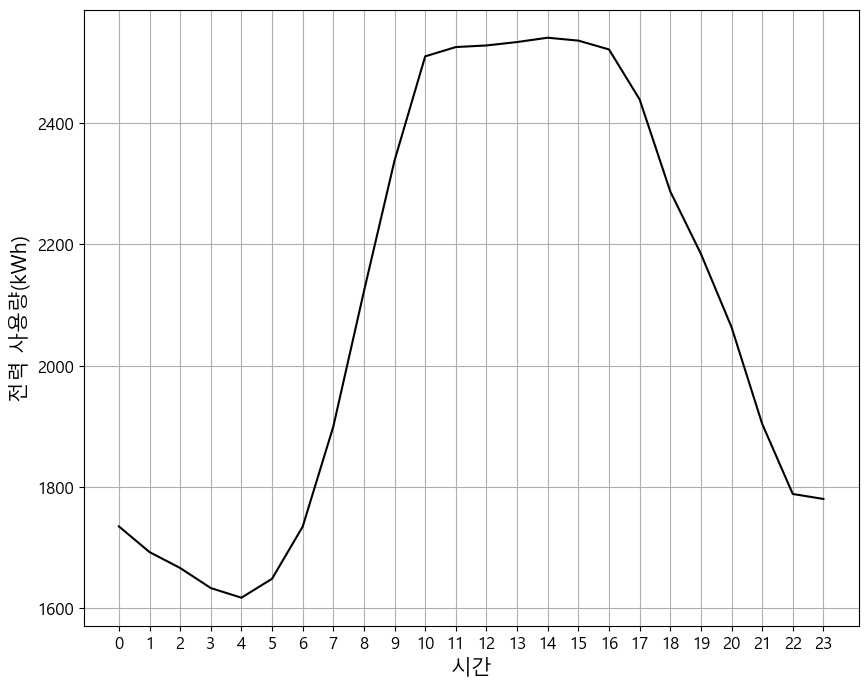

In [24]:
qq = eda_df[eda_df['태양광보유'] == 0].groupby(['hour']).mean()['전력사용량(kWh)']
plt.figure(figsize=(10,8))
plt.plot(qq, color = 'k')
plt.grid(True)
plt.yticks(fontsize = 12)
plt.xticks(np.arange(0,24,1) , fontsize = 12)
plt.xlabel('시간', fontsize = 15)
plt.ylabel('전력 사용량(kWh)', fontsize = 15)
plt.show()

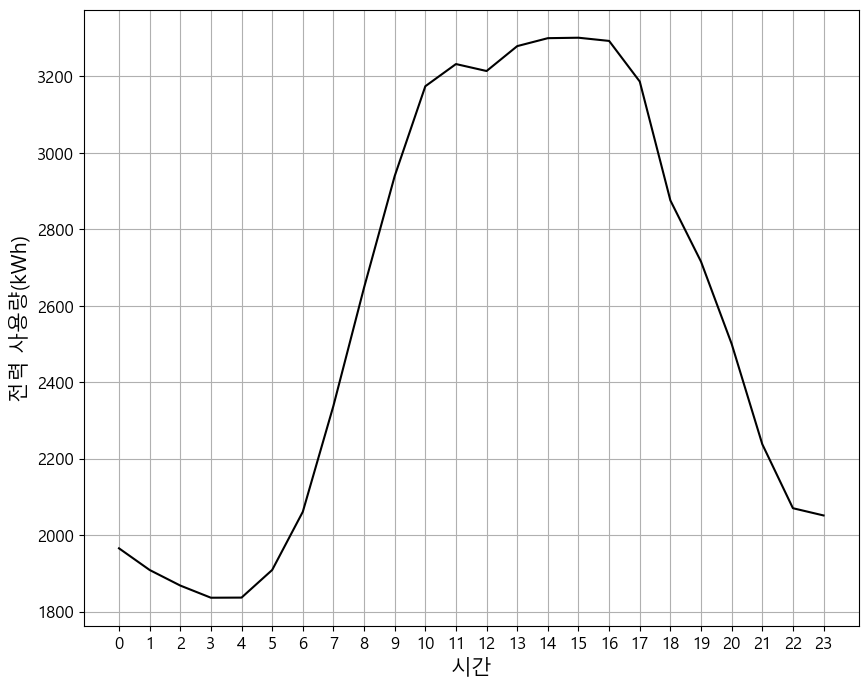

In [25]:
eda_df[eda_df['태양광보유'] == 1].groupby(['hour']).mean()['전력사용량(kWh)'].plot(figsize=(10,8), color = 'k')
plt.grid(True)
plt.yticks(fontsize = 12)
plt.xticks(np.arange(0,24,1) , fontsize = 12)
plt.xlabel('시간', fontsize = 15)
plt.ylabel('전력 사용량(kWh)', fontsize = 15)
plt.show()

<Axes: xlabel='hour'>

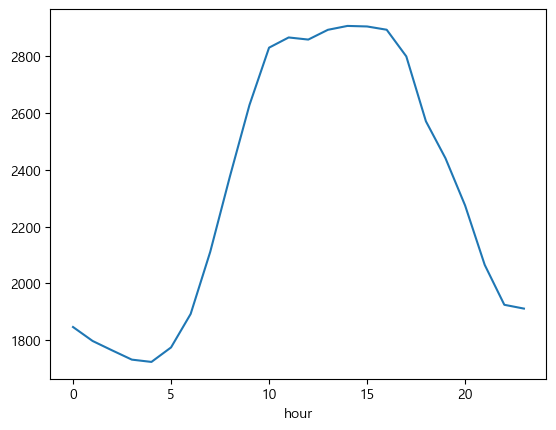

In [26]:
eda_df.groupby(['hour']).mean()['전력사용량(kWh)'].plot()

In [27]:
import numpy as np
import scipy.stats as stats

# 기존 데이터
mu = [10, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 25,
      26, 25, 24, 23, 22, 21, 20, 19, 18, 16, 14, 12]
sigma = [1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1]

# 새로운 하루의 데이터
daily_data = [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
              40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29]

# 초기 사전확률
prior = np.array([1/(len(daily_data)) for i in range(len(daily_data))])

# 베이지안 업데이트 함수
def bayesian_update(prior, likelihood):
    posterior = prior * likelihood
    posterior /= np.sum(posterior)
    return posterior

# 추론 결과
posterior_list = []

# 시간 단위로 업데이트
for i, data in enumerate(daily_data):
    # 기존 데이터의 평균과 표준편차
    mu_old = np.mean(mu[:i])
    sigma_old = np.std(mu[:i])

    # 우도
    likelihood = stats.norm(mu_old, sigma_old).pdf(data)

    # 베이지안 업데이트
    posterior = bayesian_update(prior, likelihood)
    posterior_list.append(posterior)

    # 사전확률 업데이트
    prior = posterior

# 평균값 계산
mean_posterior = np.mean(posterior_list, axis=0)

print(f"새로운 하루에 대한 사후확률의 평균값: {mean_posterior}")


새로운 하루에 대한 사후확률의 평균값: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]


In [28]:
# 가정: 시간대별로 정규분포의 평균 및 표준편차가 다름
hourly_means = np.random.normal(loc=0, scale=10, size=24)
hourly_std_devs = np.random.uniform(low=1, high=5, size=24)


In [29]:
def update(hour, new_data, alpha=0.1):
    """
    hour: 현재 시간대 (0-23)
    new_data: 새로운 데이터
    alpha: 업데이트 비율
    """
    old_mean = hourly_means[hour]
    old_std_dev = hourly_std_devs[hour]

    # 평균 업데이트
    new_mean = old_mean * (1 - alpha) + new_data * alpha

    # 표준편차 업데이트
    new_std_dev = np.sqrt((1 - alpha) * (old_std_dev ** 2) + alpha * ((new_data - old_mean) ** 2))

    # 값 업데이트
    hourly_means[hour] = new_mean
    hourly_std_devs[hour] = new_std_dev

    return new_mean


In [30]:
def predict(hour, new_data):
    updated_mean = update(hour, new_data)
    return stats.norm(updated_mean, hourly_std_devs[hour]).pdf(new_data)


In [31]:
# 샘플 데이터 생성
np.random.seed(42)
sample_hour = 14  # 14시에 대한 예시
sample_data = np.random.normal(loc=hourly_means[sample_hour], scale=hourly_std_devs[sample_hour], size=10)

# 초기 평균과 표준편차 출력
print(f"Initial mean for hour {sample_hour}: {hourly_means[sample_hour]}")
print(f"Initial std dev for hour {sample_hour}: {hourly_std_devs[sample_hour]}")

# 새로운 데이터로 평균과 표준편차 업데이트 및 사후 확률 출력
for i, data in enumerate(sample_data):
    posterior_probability = predict(sample_hour, data)
    print(f"Data {i+1}: {data}, Posterior probability: {posterior_probability}")

# 업데이트된 평균과 표준편차 출력
print(f"Updated mean for hour {sample_hour}: {hourly_means[sample_hour]}")
print(f"Updated std dev for hour {sample_hour}: {hourly_std_devs[sample_hour]}")


Initial mean for hour 14: 14.026670351079781
Initial std dev for hour 14: 4.73847804000836
Data 1: 16.38033945728486, Posterior probability: 0.07858609712991442
Data 2: 13.37150799626302, Posterior probability: 0.09053216508467123
Data 3: 17.09572826563503, Posterior probability: 0.07793207512457033
Data 4: 21.243513879946295, Posterior probability: 0.03559340353646225
Data 5: 12.917139726959405, Posterior probability: 0.08234663721125794
Data 6: 12.917217522221707, Posterior probability: 0.08690080663431708
Data 7: 21.50973559786133, Posterior probability: 0.035343030719241164
Data 8: 17.6631429623106, Posterior probability: 0.08232357745301658
Data 9: 11.8020762829806, Posterior probability: 0.06740408585914334
Data 10: 16.597579202997853, Posterior probability: 0.09322593184606039
Updated mean for hour 14: 15.378617749554849
Updated std dev for hour 14: 4.093742927316864


In [32]:
# 샘플 데이터 생성 함수
def generate_sample_data(hour, n_samples=10):
    np.random.seed(42)
    return np.random.normal(loc=hourly_means[hour], scale=hourly_std_devs[hour], size=n_samples)

# 각 시간대별로 샘플 데이터 생성
sample_data_by_hour = {hour: generate_sample_data(hour) for hour in range(24)}

# 초기 평균과 표준편차 출력
print("Initial means:", hourly_means)
print("Initial std devs:", hourly_std_devs)

# 각 시간대별로 새로운 데이터로 평균과 표준편차 업데이트 및 사후 확률 출력
for hour, sample_data in sample_data_by_hour.items():
    print(f"\nHour {hour}:")
    for i, data in enumerate(sample_data):
        posterior_probability = predict(hour, data)
        print(f"  Data {i+1}: {data}, Posterior probability: {posterior_probability}")

# 업데이트된 평균과 표준편차 출력
print("\nUpdated means:", hourly_means)
print("Updated std devs:", hourly_std_devs)


Initial means: [ 21.17823092  21.09399567   8.94442496   2.68770621  -6.96273185
   1.35047443  -3.20668158 -10.1814383    8.17994607  -2.19183579
   6.04139582 -18.67454632  10.95187493 -21.46129523  15.37861775
   7.21660565  -6.11455256  -6.17744841   5.95101198  -3.35491758
  19.29436334   1.64476117   0.65536674  -5.56759063]
Initial std devs: [4.80428575 4.02926293 3.19798916 2.57048177 2.35035482 3.83453453
 4.04753035 1.31669082 2.73152371 1.90201485 1.35955194 3.50647418
 3.43304475 1.19392022 4.09374293 1.81689301 2.18027019 2.49130306
 4.97827892 2.87122211 2.32593482 4.30343011 1.6877272  3.81537058]

Hour 0:
  Data 1: 23.564587645571773, Posterior probability: 0.07750964756152329
  Data 2: 20.5139697046797, Posterior probability: 0.08929208174181474
  Data 3: 24.28991173292536, Posterior probability: 0.07686458415994098
  Data 4: 28.495301557483618, Posterior probability: 0.035105855416964
  Data 5: 20.0532911947445, Posterior probability: 0.08121867685539526
  Data 6: 20.

In [33]:
sample_data_by_hour

{0: array([23.56458765, 20.5139697 , 24.28991173, 28.49530156, 20.05329119,
        20.05337007, 28.76522055, 24.86520665, 18.92274181, 23.7848444 ]),
 1: array([23.09538759, 20.53689244, 23.70370309, 27.23068341, 20.15053015,
        20.1505963 , 27.45705933, 24.18619197, 19.20235993, 23.28011274]),
 2: array([10.53291144,  8.50225723, 11.01572589, 13.81505794,  8.19560501,
         8.19565751, 13.99473043, 11.39867291,  7.44305097, 10.6795261 ]),
 3: array([3.96450088, 2.33230034, 4.35257779, 6.60262669, 2.08581923,
        2.08586143, 6.74704396, 4.66038319, 1.48093086, 4.08234691]),
 4: array([-5.79527735, -7.28770202, -5.44043397, -3.38307129, -7.51307536,
        -7.51303677, -3.2510214 , -5.15898794, -8.06616323, -5.68752324]),
 5: array([ 3.255142  ,  0.82029519,  3.8340585 ,  7.19058501,  0.45260523,
         0.45266819,  7.40602051,  4.2932294 , -0.44974131,  3.43093965]),
 6: array([-1.19621597, -3.76631054, -0.58514256,  2.95782799, -4.15442447,
        -4.15435802,  3.1852